In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import os, random, collections
# import pandas as pd
import cv2
import numpy as np
import pandas as pd
import scipy.ndimage

from tqdm import tqdm as tqdm
from IPython.display import clear_output

from torchvision import transforms

In [3]:
import sys
sys.path.append('..')

from utils.attributes_augmentations import Augmentation
from utils.attributes_dataset import ISIC_Dataset
from utils.cyst_enhanced import Pores
%load_ext autoreload
%autoreload 2

In [4]:
import pickle 
amounts = pickle.load(open('../data/patches_amounts.pkl', 'rb'))
attributes_areas = pickle.load(open('../data/attribute_areas.pkl', 'rb'))

train_dataset = ISIC_Dataset('../data/cropped_full/', seed=None, 
                             appearence_mean=[0., 1., 0., 0., 0., 0.],
                             augmentator=Augmentation,
                             aug_params={'side': 576},
                             is_test=True,
#                              amounts=amounts,
                             part=0, partsamount=1, exclude=False)

100%|██████████| 2594/2594 [02:51<00:00, 15.13it/s]


In [16]:
def crop(image, mask):
    coords = np.array(np.where(mask))
    x_min, x_max = coords[0].min(), coords[0].max()
    y_min, y_max = coords[1].min(), coords[1].max()
    return (
        image[x_min: x_max, y_min: y_max],
        mask[x_min: x_max, y_min: y_max],
        (x_min, x_max),
        (y_min, y_max)
    )

In [17]:
def normalize_dots(dots, labeled, colours):
    """
    Threshold enhanced images from outliers through `self.DNG_level` * sigma,
    sigma is computed from renormalized Dots Enhanced destribution.
    """
    dots_mean = list()
    dots_std = list()
    new_dot = np.zeros(dots.shape)
    for colour in range(colours):
        area = (labeled == (colour + 1)) & (dots > 0)
        
        new_dot[area] = np.log(dots[area])

        lower_bound = np.percentile(new_dot[area], 1)
        upper_bound = np.percentile(new_dot[area], 99)

        dots_mean.append(np.median(new_dot[area]))
        dots_std.append(new_dot[(new_dot > lower_bound) 
                                & (new_dot < upper_bound)].std())

        new_dot[area] = (new_dot[area] - dots_mean[-1]) / dots_std[-1]
    return new_dot

In [18]:
root_dir = '../data/ISIC2018_Task1-2_Training_Input'
template = {
    'image': 'ISIC_{}.jpg',
    'attribute': 'ISIC_{}_attribute_milia_like_cyst.png',
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


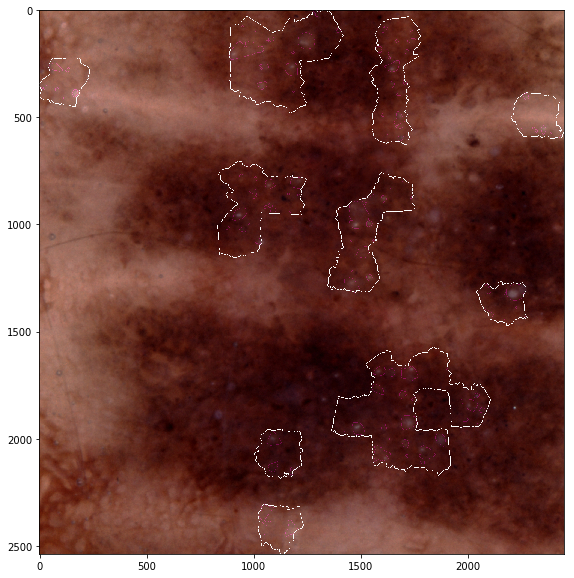






601it [47:46,  4.77s/it]

Enhs has been computed.
DNG has been computed.
Gaussian mixture has been converged for all cases
Alls has been normalized.







602it [49:25,  4.93s/it]

Enhs has been computed.
DNG has been computed.
Gaussian mixture has been converged for all cases
Alls has been normalized.







603it [49:41,  4.94s/it]

Enhs has been computed.







604it [49:44,  4.94s/it]

DNG has been computed.
Gaussian mixture has been converged for all cases
Alls has been normalized.
Enhs has been computed.
DNG has been computed.
Gaussian mixture has been converged for all cases
Alls has been normalized.







605it [49:45,  4.93s/it]

Enhs has been computed.







606it [49:50,  4.93s/it]

DNG has been computed.
Gaussian mixture has been converged for all cases
Alls has been normalized.
Enhs has been computed.
DNG has been computed.







607it [50:08,  4.96s/it]

Gaussian mixture has been converged for all cases
Alls has been normalized.
Enhs has been computed.
DNG has been computed.







608it [50:23,  4.97s/it]

Gaussian mixture has been converged for all cases
Alls has been normalized.
Enhs has been computed.
DNG has been computed.
Gaussian mixture has been converged for all cases
Alls has been normalized.







609it [51:53,  5.11s/it]

Enhs has been computed.
DNG has been computed.







610it [52:15,  5.14s/it]

Gaussian mixture has been converged for all cases
Alls has been normalized.


In [ ]:
for i, key in tqdm(enumerate(train_dataset.appearence_keys[1])):
    path = train_dataset.paths[key]['attributes'][1]
    name = os.path.basename(path).split('_')[1]
    image = cv2.imread(
        os.path.join(root_dir, template['image']).format(name))[..., ::-1] / 255.
    mask_orig = cv2.imread(
        os.path.join(root_dir, template['attribute'].format(name)), 0) > 0
    image, mask, xs, ys = crop(image, mask_orig)
    mask_ = (
        np.bitwise_not(mask) 
        & scipy.ndimage.binary_dilation(mask, iterations=3)
    )

    labeled, colours = scipy.ndimage.label(mask)
    larea = list()
    for colour in range(colours):
        larea.append(np.sqrt((labeled == (colour + 1)).sum()))
    larea = np.array(larea)

    im = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    im = im.astype(np.float)
    prepared = im[..., 1] - scipy.ndimage.gaussian_filter(
        im[..., 1], np.mean(larea) / 2
    )
    rad = larea / (2 * np.sqrt(np.pi))
    pores = Pores(rad.min(), rad.max(), detect_bright_motes=False, normalize=True)
    cysts = pores(np.array([prepared]), masks=[mask])
#     new_dots = normalize_dots(pores.dots[0], labeled, colours)
    new_dots = pores.dots[0]
    new_dots[new_dots < 0] = 0
    dots = (new_dots * scipy.ndimage.binary_erosion(mask) * (new_dots > 0)) > 2
    dots = scipy.ndimage.binary_opening(dots, iterations=2)

    if (i) % 10 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(10, 10))
        dots_ = (
            scipy.ndimage.binary_erosion(np.bitwise_not(dots)) 
            & scipy.ndimage.binary_dilation(dots, iterations=3)
        )
        image[..., 0] += dots_ / 4.
        image[..., 2] += dots_ / 4.
        plt.imshow(image + np.expand_dims(mask_, -1))
        plt.show()

    mask = np.zeros_like(mask_orig)
    mask[xs[0]: xs[1], ys[0]: ys[1]] = dots
    np.save(out_path.format(name), mask.astype(np.bool_))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


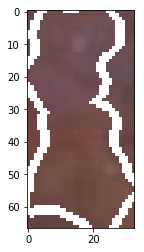

In [20]:
plt.imshow(image + np.expand_dims(mask_, -1))

In [33]:
out_path = '../data/Task2Cysts/ISIC_{}'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Enhs has been computed.
DNG has been computed.
Gaussian mixture has been converged for all cases
Alls has been normalized.


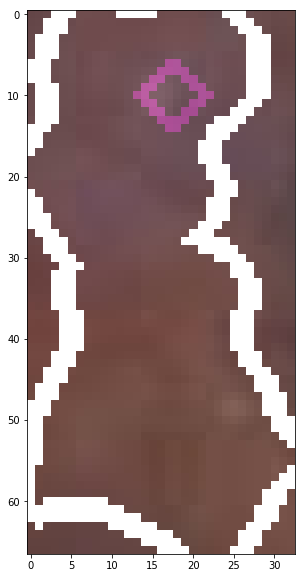

8